In [4]:
import pandas as pd
import os
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown

import sys
sys.path.append('../')

from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utilities import data, roc, threshold, output, info
from utilities.info import *

In [5]:
FIG_DIR = f"{TEAMS_DIR}/melba-figs"
TAB_DIR = f"{TEAMS_DIR}/melba-tables"

print("FILES:\t", FILE_DIR)
print("RESULT:\t", RESULTS_DIR)
print("FIGS:\t", FIG_DIR)
print("TABLES:\t", TAB_DIR)

FILES:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/files
RESULT:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/fairness-analysis-results
FIGS:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/melba-figs
TABLES:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/melba-tables


In [6]:
POLICIES_TO_USE = ['90% Sensitivity', '90% Specificity', 'Brock ILST (6%)']
TABLE_SCORE_PRECISION = 2
MIN_MAL = 15
TOP_N_CONFOUNDERS = 10

In [7]:
nlst_preds_nodule = pd.read_csv(f"{FILE_DIR}/nlst_allmodels_demos.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 127 entries, PatientID to study
dtypes: bool(27), float64(85), int64(11), object(4)
memory usage: 12.7+ MB


In [8]:
with open(f'{FILE_DIR}/nlst_democols.json') as json_data:
    nlst_democols_og = json.load(json_data)
    json_data.close()

nlst_democols_og

{'num': {'demo': ['weight', 'height', 'BMI', 'Age'],
  'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr'],
  'nodule': ['CoordX', 'CoordY', 'CoordZ'],
  'other': ['Diameter_mm', 'NoduleCounts']},
 'cat': {'demo': ['Overweight',
   'race',
   'ethnic',
   'Unfinished_ed',
   'educat',
   'NonHispanicWhite',
   'WhiteOrBlack',
   'marital',
   'Married',
   'HighSchoolPlus',
   'Gender'],
  'smoke': ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework'],
  'work': ['wrkasbe',
   'wrkbaki',
   'wrkbutc',
   'wrkchem',
   'wrkcoal',
   'wrkcott',
   'wrkfarm',
   'wrkfire',
   'wrkflou',
   'wrkfoun',
   'wrkhard',
   'wrkpain',
   'wrksand',
   'wrkweld'],
  'disease': ['diagadas',
   'diagasbe',
   'diagbron',
   'diagchas',
   'diagchro',
   'diagcopd',
   'diagdiab',
   'diagemph',
   'diagfibr',
   'diaghear',
   'diaghype',
   'diagpneu',
   'diagsarc',
   'diagsili',
   'diagstro',
   'diagtube'],
  'canchist': ['cancblad',
   'cancbrea',
   'canccerv',
   'canccolo',
   'cancesop

# Materials

## Demographic characteristics of the NLST validation set (n=5911 scans).

In [9]:
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_1172, nlst_democols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=True, sybil=True, pretty=True, bin_num=False)
len(nlst_5911), len(nlst_1172)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:479: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:479: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


(5911, 1172)

In [79]:
nlst_5911['PatientID'].nunique()

3492

In [10]:
nlstval_full_mal = nlst_5911.query('label == 1')
nlstval_full_ben = nlst_5911.query('label == 0')
print('full:', len(nlstval_full_ben), 'ben', len(nlstval_full_mal), 'mal')

nlstval_some_mal = nlst_1172.query('label == 1')
nlstval_some_ben = nlst_1172.query('label == 0')
print('some:', len(nlstval_some_ben), 'ben', len(nlstval_some_mal), 'mal')

full: 5330 ben 581 mal
some: 1045 ben 127 mal


In [ ]:
validation_sets = {
    "Full (malignant)": nlstval_full_mal,
    "Full (benign)": nlstval_full_ben,
    # "Full (all)": nlst_5911,
}

In [12]:
cat_df0 = data.combine_diff_dfs(nlst_democols['cat'], data.diffs_category_prevalence, validation_sets)
cat_df = cat_df0.copy(deep=True)
for s in validation_sets:
    cat_df[f"{s}_info"] = cat_df.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_df = cat_df[['category', 'attribute', 'value'] + [f"{s}_info" for s in validation_sets]].dropna(axis=0)
cat_df = cat_df.set_index(pd.MultiIndex.from_frame(cat_df[['category', 'attribute', 'value']]))[[f"{s}_info" for s in validation_sets]]

In [ ]:
attribute_valid_subgroups_5911 = cat_df0[cat_df0['Full (malignant)_freq'] > 15][['attribute', 'value', 'Full (malignant)_freq']].groupby('attribute')['value'].count()
invalid_attributes_5911 = list(attribute_valid_subgroups_5911[attribute_valid_subgroups_5911 < 2].index)

total_categorical_columns = cat_df0['attribute'].nunique()
print("invalid:", len(invalid_attributes_5911))
print("valid:", total_categorical_columns - len(invalid_attributes_5911))

invalid: 36
valid: 47


In [14]:
num_df = data.combine_diff_dfs(nlst_democols['num'], data.diffs_numerical_means, validation_sets)
num_df = num_df[(num_df['value'].isin(['Median (IQR)']))][['category', 'attribute', 'value'] + [f"{s}" for s in validation_sets]].dropna(axis=0)
num_df = num_df.set_index(pd.MultiIndex.from_frame(num_df[['category', 'attribute', 'value']]))[[f"{s}" for s in validation_sets]]

In [ ]:
multicol_idx = pd.MultiIndex.from_tuples([
    ('NLST Dataset (n=5911 Scans)', 'Malignant (n=581)'),
    ('NLST Dataset (n=5911 Scans)', 'Benign (n=5330)'),
    # ('NLST Dataset (n=5911 Scans)', 'Total'),
])

cat_df.columns = multicol_idx
num_df.columns = multicol_idx

In [16]:
df_out = pd.concat([cat_df, num_df], axis=0)
df_out

NLST Dataset (n=5911 Scans)  \
                                                                 Malignant (n=581)   
category     attribute              value                                            
Demographics BMI                    < 25                                209 (36.0)   
                                    ≥ 25                                372 (64.0)   
             Race                   Asian                                  6 (1.0)   
                                    Black                                 28 (4.8)   
                                    More than one race                     6 (1.0)   
...                                                                            ...   
Smoking      Age at Smoking Onset   Median (IQR)                            16 (4)   
             Cigarettes per Day     Median (IQR)                           30 (20)   
             Total Years of Smoking Median (IQR)                           44 (10)   
Other        Diameter (mm)          Median (IQR)                            12 (9)   
             Nodules Per Scan       Median (IQR)                             2 (2)   

                                                                        
                                                       Benign (n=5330)  
category     attribute              value                               
Demographics BMI                    < 25                   1690 (31.7)  
                                    ≥ 25                   3640 (68.3)  
             Race                   Asian                     66 (1.2)  
                                    Black                    160 (3.0)  
                                    More than one race        59 (1.1)  
...                                                                ...  
Smoking      Age at Smoking Onset   Median (IQR)                16 (3)  
             Cigarettes per Day     Median (IQR)               25 (15)  
             Total Years of Smoking Median (IQR)               41 (10)  
Other        Diameter (mm)          Median (IQR)                 6 (4)  
             Nodules Per Scan       Median (IQR)                 1 (1)  

[192 rows x 2 columns]

In [17]:
df_out2 = df_out.xs('Demographics', level='category')
df_out2

NLST Dataset (n=5911 Scans)  \
                                                   Malignant (n=581)   
attribute            value                                             
BMI                  < 25                                 209 (36.0)   
                     ≥ 25                                 372 (64.0)   
Race                 Asian                                   6 (1.0)   
                     Black                                  28 (4.8)   
                     More than one race                      6 (1.0)   
                     Native American                         8 (1.4)   
                     Native Hawaiian                         1 (0.2)   
                     White                                530 (91.2)   
Ethnicity            Hispanic/Latino                         4 (0.7)   
                     Not Hispanic/Latino                  574 (98.8)   
Unfinished Education False                                423 (72.8)   
                     True                                 158 (27.2)   
Education Status     8th grade or less                       9 (1.5)   
                     9th-11th grade                         32 (5.5)   
                     Associate Degree                     126 (21.7)   
                     Bachelors Degree                      96 (16.5)   
                     Graduate School                       76 (13.1)   
                     HS Graduate / GED                    141 (24.3)   
                     Post-HS training                      87 (15.0)   
Non-Hispanic White   False                                  55 (9.5)   
                     True                                 526 (90.5)   
White or Black       Black                                  28 (4.8)   
                     White                                530 (91.2)   
Marital Status       Divorced                             125 (21.5)   
                     Married                              384 (66.1)   
                     Never Married                          16 (2.8)   
                     Separated                               5 (0.9)   
                     Widowed                                49 (8.4)   
Married              False                                197 (33.9)   
                     True                                 384 (66.1)   
HS Education         False                                   9 (1.5)   
                     True                                 572 (98.5)   
Gender               Female                               244 (42.0)   
                     Male                                 337 (58.0)   
Weight               Median (IQR)                           175 (50)   
Height               Median (IQR)                             68 (6)   
Body Mass Index      Median (IQR)                             26 (4)   
Age                  Median (IQR)                             64 (8)   

                                                          
                                         Benign (n=5330)  
attribute            value                                
BMI                  < 25                    1690 (31.7)  
                     ≥ 25                    3640 (68.3)  
Race                 Asian                      66 (1.2)  
                     Black                     160 (3.0)  
                     More than one race         59 (1.1)  
                     Native American            15 (0.3)  
                     Native Hawaiian            17 (0.3)  
                     White                   4993 (93.7)  
Ethnicity            Hispanic/Latino            94 (1.8)  
                     Not Hispanic/Latino     5205 (97.7)  
Unfinished Education False                   3897 (73.1)  
                     True                    1433 (26.9)  
Education Status     8th grade or less         102 (1.9)  
                     9th-11th grade            258 (4.8)  
                     Associate Degree        1175 (22.0)  
                     Bache

In [18]:
print(df_out2.style.format(precision=1, na_rep='-').format_index(output.latex_replace_arrowbrackets).format(output.latex_replace_arrowbrackets).to_latex(
    buf=f"{TAB_DIR}/datasetDemos.tex",
    hrules=True, label='tab:datasetDemos', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the NLST validation set (n={len(nlst_5911)} scans). HS = High School.'))

None


## DLCST vs. NLST

NOTE: unused in MELBA paper right now. If we want to have DLCST, then we should probably keep this in.

In [19]:
nlst_valset, nlst_cols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
dlcst_preds = pd.read_csv(f"{FILE_DIR}/dlcst_allmodels_cal.csv", header=0)
dlcst_valset, dlcst_cols = data.nlst_pretty_labels(dlcst_preds, DLCST_DEMOCOLS)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:479: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:479: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [20]:
popshift_check = {
    "NLST_mal": nlst_valset.query('label == 1'),
    "NLST_ben": nlst_valset.query('label == 0'),
    # "NLST_full": nlst_valset,
    "DLCST_mal": dlcst_valset.query('label == 1'),
    "DLCST_ben": dlcst_valset.query('label == 0'),
    # "DLCST_full": dlcst_valset,   
}

popshift_multi_idx = pd.MultiIndex.from_tuples([
    ('NLST Validation (n=5911 Scans)', 'Malignant (n=581)'),
    ('NLST Validation (n=5911 Scans)', 'Benign (n=5330)'),
    # ('NLST Validation (n=5911 Scans)', 'Total'),
    ('DLCST Validation (n=599 Scans)', 'Malignant (n=59)'),
    ('DLCST Validation (n=599 Scans)', 'Benign (n=540)'),
    # ('DLCST Validation (n=599 Scans)', 'Total'),
])

df_popshift = data.combine_diff_dfs(dlcst_cols['cat'], dfsets=popshift_check, dispdf=False)
for s in popshift_check:
    df_popshift[f"{s}_info"] = df_popshift.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_multiidx = pd.MultiIndex.from_frame(df_popshift[['attribute', 'value']])
df_popshift = df_popshift.set_index(cat_multiidx)[[f"{s}_info" for s in popshift_check]]
df_popshift.columns = popshift_multi_idx

In [21]:
num_popshift = data.combine_diff_dfs(dlcst_cols['num'], df_func=data.diffs_numerical_means, dfsets=popshift_check, dispdf=False)
num_popshift = num_popshift[
    (num_popshift['category'] == "Demographics") & (num_popshift['value'].isin(['Median (IQR)']))
    # & (df['attribute'].isin(['Gender', 'Race', 'Education Status', 'Marital Status', 'Ethnic']))
][['attribute', 'value'] + [f"{s}" for s in popshift_check]].dropna(axis=0)
num_popshift = num_popshift.set_index(pd.MultiIndex.from_frame(num_popshift[['attribute', 'value']]))[[f"{s}" for s in popshift_check]]
num_popshift.columns = popshift_multi_idx

In [22]:
df_popshift = pd.concat([df_popshift, num_popshift], axis=0)
df_popshift

NLST Validation (n=5911 Scans)  \
                                               Malignant (n=581)   
attribute            value                                         
Gender               Female                           244 (42.0)   
                     Male                             337 (58.0)   
Family History of LC False                            401 (69.0)   
                     True                             180 (31.0)   
Emphysema in Scan    False                            317 (54.6)   
                     True                             264 (45.4)   
Age                  Median (IQR)                         64 (8)   

                                                   \
                                  Benign (n=5330)   
attribute            value                          
Gender               Female           2226 (41.8)   
                     Male             3104 (58.2)   
Family History of LC False            3983 (74.7)   
                     True             1347 (25.3)   
Emphysema in Scan    False            3438 (64.5)   
                     True             1892 (35.5)   
Age                  Median (IQR)          62 (8)   

                                  DLCST Validation (n=599 Scans)  \
                                                Malignant (n=59)   
attribute            value                                         
Gender               Female                            27 (45.8)   
                     Male                              32 (54.2)   
Family History of LC False                             43 (72.9)   
                     True                              16 (27.1)   
Emphysema in Scan    False                             15 (25.4)   
                     True                              44 (74.6)   
Age                  Median (IQR)                         62 (7)   

                                                  
                                  Benign (n=540)  
attribute            value                        
Gender               Female           249 (46.1)  
                     Male             291 (53.9)  
Family History of LC False            454 (84.1)  
                     True              86 (15.9)  
Emphysema in Scan    False            179 (33.1)  
                     True             361 (66.9)  
Age                  Median (IQR)         58 (7)

In [23]:
print(df_popshift.style.format(precision=1, na_rep='-').to_latex(
    buf=f"{TAB_DIR}/populationShift.tex",
    hrules=True, label='tab:populationShift', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the DLCST validation set (n=599 scans), compared to those from the NLST validation set (n=5911 scans).'))

None


# Methods

### Thresholds from policies on validation sets.

In [46]:
dlcst_policies, _ = threshold.get_threshold_policies(dlcst_preds, models=output.DLCST_MODELCOLS, policies=[("Sensitivity", 0.9),("Specificity", 0.9)], brock=True)

In [26]:
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_5911_policies, _ = threshold.get_threshold_policies(nlst_5911, models=output.NLST_5911_MODELCOLS, policies=[("Sensitivity", 0.9),("Specificity", 0.9)], brock=False)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:479: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [27]:
nlst_5911_policies.rename(columns=output.RENAME_POLICIES, inplace=True)
nlst_5911_policies

,90% Sensitivity,90% Specificity
Venkadesh21,0.049,0.222
Sybil (Year 1),0.003,0.058
PanCan2b,0.015,0.165


In [28]:
print(nlst_5911_policies.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/thresholds.tex",
    hrules=True, label='tab:thresholds', environment='table', column_format='l|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='Thresholds used to evaluate model performance the NLST validation set. All models are also evaluated on the ILST moderate risk threshold of 6\% (0.06) \citep{Lim2020-ilst}.'))

None


If we also want to include DLCST policies, we can do that here.

In [ ]:
# policy_dfs = {
#     # "DLCST (n=599)": dlcst_policies.copy(deep=True), 
#     "NLST (n=5911)": nlst_5911_policies.copy(deep=True)
# }

# for val in policy_dfs:
#     if 'Brock' in policy_dfs[val].columns:
#         policy_dfs[val].drop(columns='Brock', inplace=True)
#     policy_dfs[val].rename(columns={'Sensitivity=0.9': '90\% Sensitivity', 'Specificity=0.9': '90\% Specificity'}, inplace=True)

# combined_policies = pd.concat(policy_dfs, axis=1).sort_index(ascending=False)
# combined_policies = combined_policies[combined_policies.index != 'De Haas Global (Shown Nodule)']
# combined_policies

In [ ]:
# print(combined_policies.style
        # .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        # .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        # .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0).to_latex(
#     buf=f"{TAB_DIR}/thresholds.tex",
#     hrules=True, label='tab:thresholds', environment='table*', column_format='l|rr|rr|rr', position='h!',
#     multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
#     caption='Thresholds used to evaluate model performance on DLCST and NLST validation datasets. All models are also evaluated on the ILST moderate risk threshold of 6\% (0.06) \citep{Lim2020-ilst}.'))

# Results

## ROC Tables

### DLCST

In [31]:
dlcst_results = pd.read_csv(f"{RESULTS_DIR}/auroc-dlcst-599.csv", index_col=0)
dlcst_model_order = ['Venkadesh', 'Sybil year 1', 'PanCan2b']
dlcst_out = output.roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
dlcst_out_demos = dlcst_out.xs('Demographics', level='Category')
dlcst_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_12820\1406022195.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dlcst_out = output.roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh21           Sybil (Year 1)        \
                            ROC AUC     p            ROC AUC     p   
Attribute Group                                                      
Age       > 61    0.92 (0.87, 0.97)  None  0.86 (0.78, 0.94)  None   
          ≤ 61    0.92 (0.85, 0.97)   .99  0.86 (0.78, 0.93)   .98   
Gender    Male    0.91 (0.84, 0.96)  None  0.87 (0.78, 0.94)  None   
          Female  0.94 (0.91, 0.97)   .44  0.86 (0.78, 0.93)   .88   

                           PanCan2b        
                            ROC AUC     p  
Attribute Group                            
Age       > 61    0.85 (0.79, 0.91)  None  
          ≤ 61    0.90 (0.84, 0.95)   .46  
Gender    Male    0.91 (0.86, 0.95)  None  
          Female  0.86 (0.79, 0.92)   .35

In [32]:
print(dlcst_out_demos.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoROC.tex",
    hrules=True, label='tab:resDLCSTdemoROC', environment='table*', column_format=f'll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for models on demographic characteristics when evaluated on the DLCST validation set (599 scans), including p values. No significant demographic biases were found from any of our models on the DLCST cohort.'))

None


### NLST 5911

In [33]:
nlst_demos_to_include = ['Age', 'Gender', 'Race', 'HS Education', 'Height', 'Weight', 'BMI']

In [34]:
nlst_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-5911.csv", index_col=0)
nlst_model_order = ['Venkadesh', 'Sybil year 1', 'PanCan2b']
nlst_scan_out = output.roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_scan_out_demos = nlst_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include & Attribute not in @invalid_attributes_5911')
nlst_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_12820\1404112098.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_scan_out = output.roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh21           Sybil (Year 1)          \
                            ROC AUC     p            ROC AUC       p   
Attribute Group                                                        
Age       > 61    0.88 (0.86, 0.90)  None  0.84 (0.82, 0.86)    None   
          ≤ 61    0.90 (0.88, 0.92)   .14  0.85 (0.82, 0.88)     .67   
BMI       ≥ 25    0.90 (0.88, 0.91)  None  0.86 (0.84, 0.88)    None   
          < 25    0.88 (0.85, 0.90)   .32  0.81 (0.78, 0.85)     .05   
Gender    Male    0.89 (0.87, 0.91)  None  0.81 (0.78, 0.84)    None   
          Female  0.89 (0.87, 0.91)   .92  0.88 (0.86, 0.90)  < .001   
Height    ≤ 68    0.89 (0.87, 0.91)  None  0.87 (0.85, 0.89)    None   
          > 68    0.88 (0.86, 0.91)   .67  0.80 (0.77, 0.83)  < .001   
Race      White   0.89 (0.88, 0.91)  None  0.84 (0.83, 0.86)    None   
          Black   0.82 (0.74, 0.89)   .14  0.83 (0.74, 0.90)     .77   
Weight    ≤ 180   0.88 (0.87, 0.90)  None  0.84 (0.82, 0.87)    None   
          > 180   0.89 (0.87, 0.91)   .65  0.84 (0.81, 0.87)     .82   

                           PanCan2b        
                            ROC AUC     p  
Attribute Group                            
Age       > 61    0.76 (0.74, 0.79)  None  
          ≤ 61    0.81 (0.78, 0.83)   .05  
BMI       ≥ 25    0.81 (0.79, 0.83)  None  
          < 25    0.73 (0.70, 0.77)  .001  
Gender    Male    0.79 (0.76, 0.81)  None  
          Female  0.78 (0.75, 0.81)   .66  
Height    ≤ 68    0.79 (0.76, 0.81)  None  
          > 68    0.78 (0.75, 0.80)   .71  
Race      White   0.78 (0.76, 0.80)  None  
          Black   0.75 (0.65, 0.83)   .54  
Weight    ≤ 180   0.77 (0.74, 0.79)  None  
          > 180   0.80 (0.77, 0.82)   .13

In [35]:
print(nlst_scan_out_demos.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTscanROC.tex",
    hrules=True, label='tab:resNLSTscanROC', environment='table*', column_format=f'll{"|ll"*len(nlst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for models on demographic characteristics when evaluated on the NLST validation set (5911 scans), including p values.'))

None


## ROC Plots

,num,pct,mal,ben,pct_mal
Female,2470,41.7865,244,2226,9.878543
Male,3441,58.2135,337,3104,9.793665


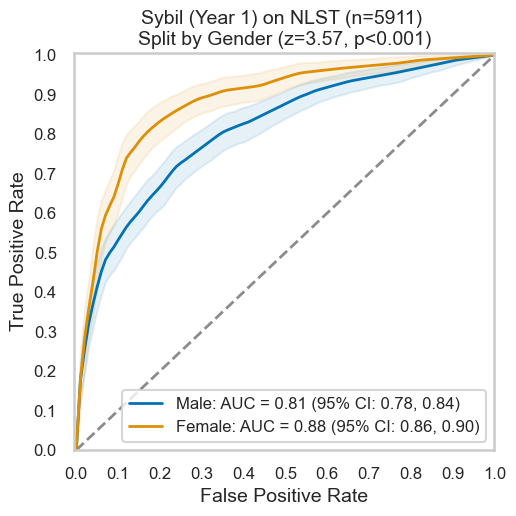

,p,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,AUC_diff
Sybil (Year 1),0.000363,Male,0.810375,0.783843,0.836403,Female,0.881035,0.856631,0.903728,0.07066


In [36]:
_ = roc.plot_rocs_subgroups(nlst_5911, 'Gender', models={'Sybil (Year 1)': 'sybil_year1'}, two_subgroups=True, dataset_name="NLST", num_bootstraps=1000, imgpath=f"{FIG_DIR}/sybilROCgender5911.png")

,num,pct,mal,ben,pct_mal
< 25,1899,32.126544,209,1690,11.005793
≥ 25,4012,67.873456,372,3640,9.272183


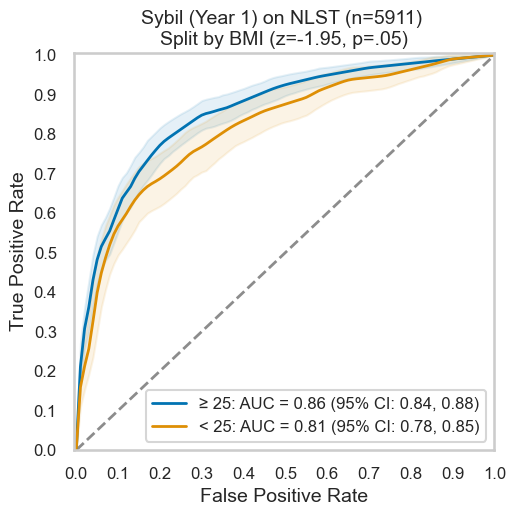

,p,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,AUC_diff
Sybil (Year 1),0.051435,≥ 25,0.856063,0.835375,0.87804,< 25,0.814306,0.779593,0.847962,-0.041758


In [37]:
_ = roc.plot_rocs_subgroups(nlst_5911, 'BMI', models={'Sybil (Year 1)': 'sybil_year1'}, two_subgroups=True, dataset_name="NLST", num_bootstraps=1000, imgpath=f"{FIG_DIR}/sybilBMIroc5911.png")

,num,pct,mal,ben,pct_mal
False,3755,63.52563,317,3438,8.442077
True,2156,36.47437,264,1892,12.244898


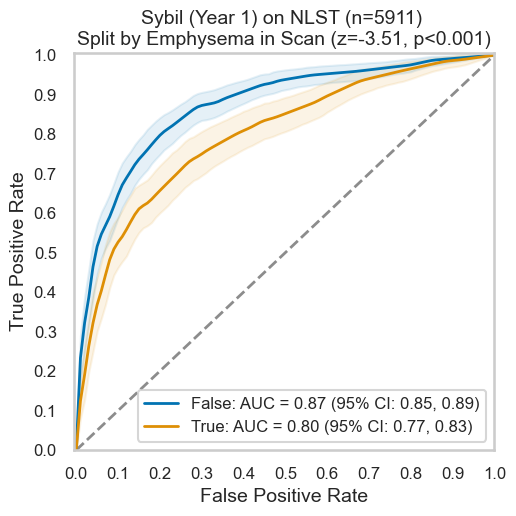

,p,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,AUC_diff
Sybil (Year 1),0.000453,False,0.869197,0.847325,0.889735,True,0.79729,0.767805,0.828122,-0.071907


In [38]:
_ = roc.plot_rocs_subgroups(nlst_5911, 'Emphysema in Scan', models={'Sybil (Year 1)': 'sybil_year1'}, two_subgroups=True, dataset_name="NLST", num_bootstraps=1000, imgpath=f"{FIG_DIR}/sybilROCemphysema5911.png")

## Threshold Utilities

In [47]:
dlcst_preds_pretty, _ = data.nlst_pretty_labels(dlcst_preds, DLCST_DEMOCOLS)
threshold_dlcst = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-dlcst-{len(dlcst_preds)}.csv', index_col=0)
threshold_dlcst, dlcst_policies = output.threshold_stats_pretty(threshold_dlcst, dlcst_policies)

In [48]:
threshold_nlst_5911 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-5911.csv', index_col=0)
threshold_nlst_5911, nlst_5911_policies = output.threshold_stats_pretty(threshold_nlst_5911, nlst_5911_policies)

## Threshold Plots

### DLCST

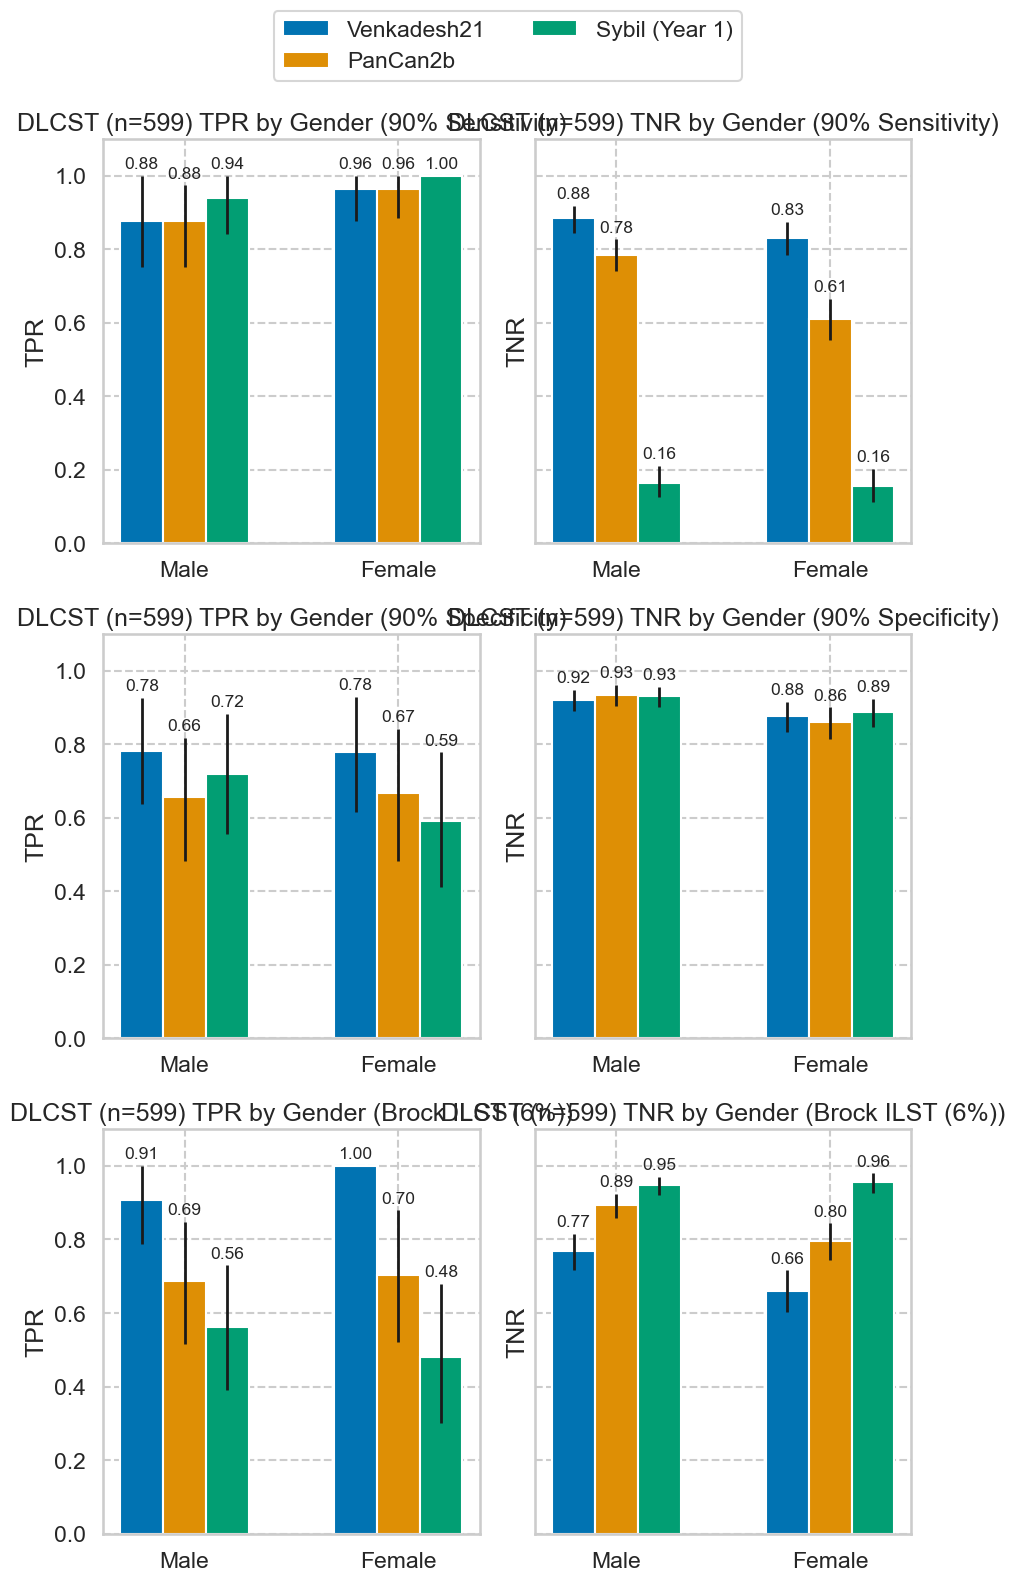

In [49]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Gender', dataset_name='DLCST',
                                             policies=dlcst_policies, models=output.DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Gender"'),
                                             plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTsex.png"
                                            )

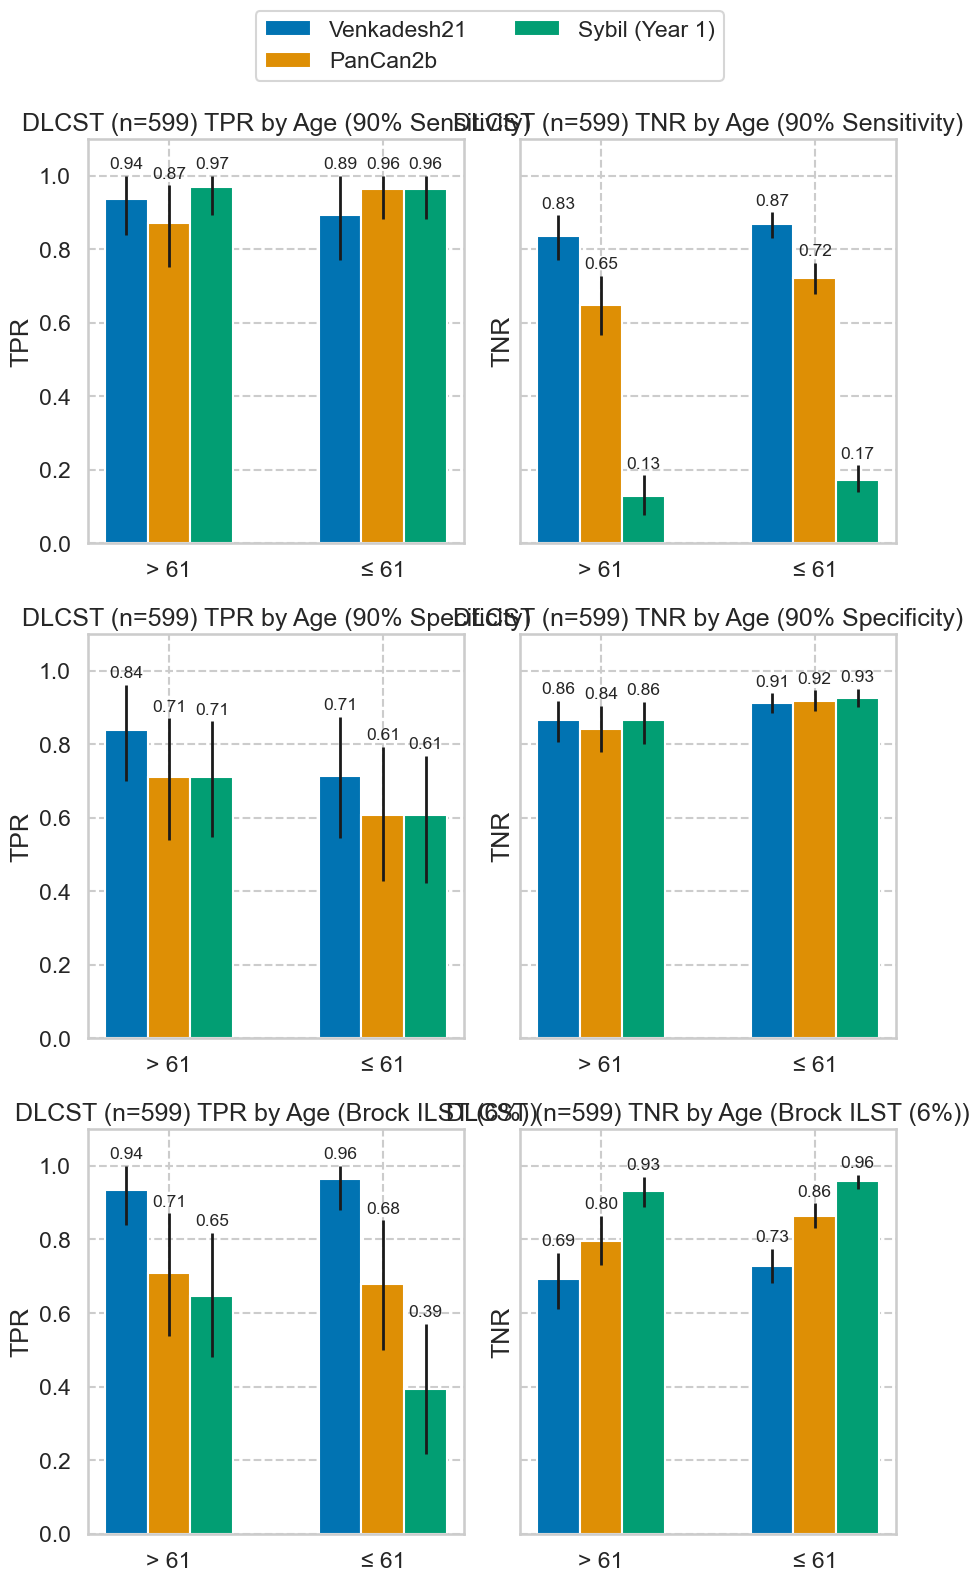

In [50]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Age', dataset_name='DLCST',
                                             policies=dlcst_policies, models=output.DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Age"'),
                                             plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTage.png"
                                            )

### NLST 5911


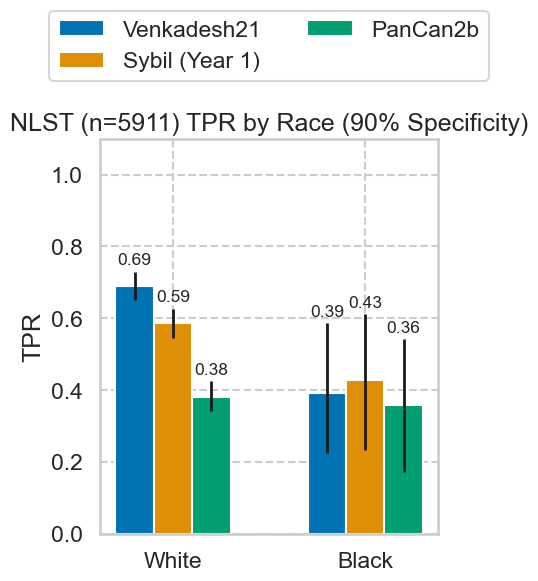

In [51]:
_ = threshold.plot_threshold_stats_subgroups(nlst_5911, "Race", dataset_name='NLST',
                                                policies=nlst_5911_policies[['90% Specificity']], models=output.NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "Race"'),
                                                plot_metrics=['TPR'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/allTPRrace5911.png"
                                                )  

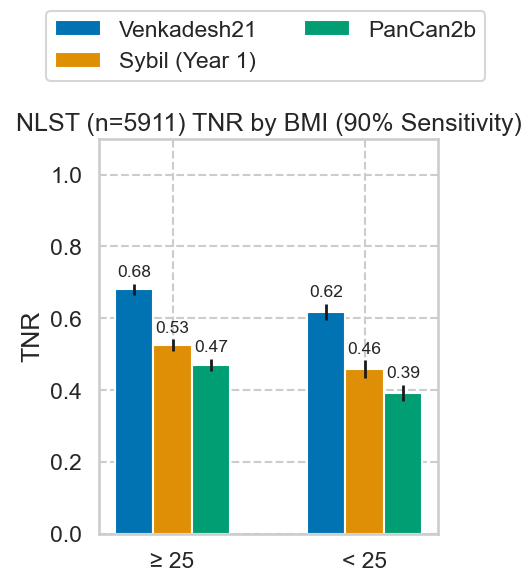

In [52]:
_ = threshold.plot_threshold_stats_subgroups(nlst_5911, "BMI", dataset_name='NLST',
                                                policies=nlst_5911_policies[['90% Sensitivity']], models=output.NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "BMI"'),
                                                plot_metrics=['TNR'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/allTNRbmi5911.png"
                                                )  

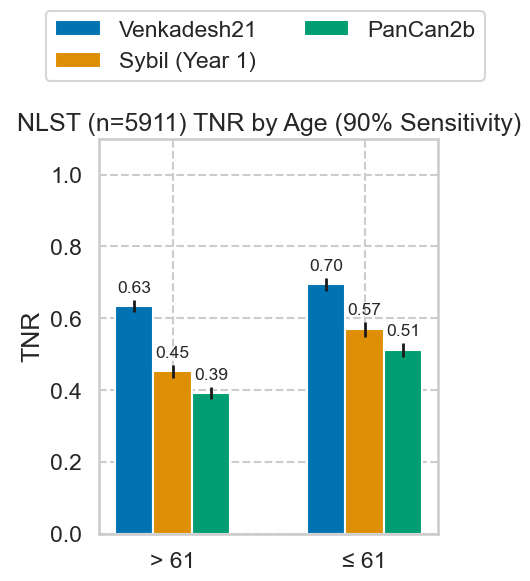

In [53]:
_ = threshold.plot_threshold_stats_subgroups(nlst_5911, "Age", dataset_name='NLST',
                                                policies=nlst_5911_policies[['90% Sensitivity']], models=output.NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "Age"'),
                                                plot_metrics=['TNR'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/allTNRage5911.png"
                                                )  

#### all columns

In [54]:
# print(nlst_demos_to_include)
# for col in nlst_demos_to_include:
#     _ = threshold.plot_threshold_stats_subgroups(nlst_5911, col, dataset_name='NLST',
#                                                 policies=nlst_5911_policies, models=output.NLST_5911_MODELCOLS, 
#                                                 stats=threshold_nlst_5911.query(f'attribute == "{col}"'),
#                                                 plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
#                                                 imgpath=f"{FIG_DIR}/threshold-NLST-5911/{col}.png"
#                                                 )  

## Threshold Tables

### DLCST

In [55]:
dlcst_demos_to_include = ['Age', 'Gender']
pairwise_tpr_dlcst = threshold.all_attribute_pairwise_comparisons(threshold_dlcst, metric="TPR")
threshold_tpr_dlcst = output.threshold_results_pretty(pairwise_tpr_dlcst, model_order=list(output.DLCST_MODELCOLS.keys()), metric='TPR')
tpr_dlcst_demo = threshold_tpr_dlcst.xs("Demographics", level='Category').query('Attribute in @dlcst_demos_to_include & Policy in @POLICIES_TO_USE')
tpr_dlcst_demo

Venkadesh21              PanCan2b     \
                                                TPR CI                TPR CI   
Policy          Attribute Group                                                
90% Sensitivity Age       > 61    0.94 (0.84, 1.00)     0.87 (0.75, 0.97)      
                          ≤ 61    0.89 (0.77, 1.00)     0.96 (0.88, 1.00)      
                Gender    Male    0.88 (0.75, 1.00)     0.88 (0.75, 0.97)      
                          Female  0.96 (0.88, 1.00)     0.96 (0.88, 1.00)      
90% Specificity Age       > 61    0.84 (0.70, 0.96)     0.71 (0.54, 0.87)      
                          ≤ 61    0.71 (0.55, 0.88)     0.61 (0.43, 0.79)      
                Gender    Male    0.78 (0.64, 0.93)     0.66 (0.48, 0.82)      
                          Female  0.78 (0.62, 0.93)     0.67 (0.48, 0.84)      
Brock ILST (6%) Age       > 61    0.94 (0.84, 1.00)     0.71 (0.54, 0.87)      
                          ≤ 61    0.96 (0.88, 1.00)     0.68 (0.50, 0.85)      
                Gender    Male    0.91 (0.79, 1.00)     0.69 (0.52, 0.85)      
                          Female  1.00 (1.00, 1.00)     0.70 (0.52, 0.88)      

                                     Sybil (Year 1)     
                                                TPR CI  
Policy          Attribute Group                         
90% Sensitivity Age       > 61    0.97 (0.89, 1.00)     
                          ≤ 61    0.96 (0.88, 1.00)     
                Gender    Male    0.94 (0.84, 1.00)     
                          Female  1.00 (1.00, 1.00)     
90% Specificity Age       > 61    0.71 (0.55, 0.86)     
                          ≤ 61    0.61 (0.42, 0.77)     
                Gender    Male    0.72 (0.56, 0.88)     
                          Female  0.59 (0.41, 0.78)     
Brock ILST (6%) Age       > 61    0.65 (0.48, 0.82)     
                          ≤ 61    0.39 (0.22, 0.57)  *  
                Gender    Male    0.56 (0.39, 0.73)     
                          Female  0.48 (0.30, 0.68)

In [56]:
print(tpr_dlcst_demo.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoTPR.tex",
    hrules=True, label='tab:resDLCSTdemoTPR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (TPR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the DLCST validation set (n=599 scans). Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [57]:
pairwise_tnr_dlcst = threshold.all_attribute_pairwise_comparisons(threshold_dlcst, metric='TNR')
threshold_tnr_dlcst = output.threshold_results_pretty(pairwise_tnr_dlcst, model_order=list(output.DLCST_MODELCOLS.keys()), metric='TNR')
tnr_dlcst_demo = threshold_tnr_dlcst.xs("Demographics", level='Category').query('Attribute in @dlcst_demos_to_include & Policy in @POLICIES_TO_USE')
tnr_dlcst_demo

Venkadesh21               PanCan2b  \
                                                TNR  CI                TNR   
Policy          Attribute Group                                              
90% Sensitivity Age       > 61    0.83 (0.77, 0.89)      0.65 (0.57, 0.73)   
                          ≤ 61    0.87 (0.83, 0.90)      0.72 (0.68, 0.76)   
                Gender    Male    0.88 (0.84, 0.92)      0.78 (0.74, 0.83)   
                          Female  0.83 (0.78, 0.87)   *  0.61 (0.55, 0.66)   
90% Specificity Age       > 61    0.86 (0.81, 0.92)      0.84 (0.78, 0.90)   
                          ≤ 61    0.91 (0.88, 0.94)      0.92 (0.89, 0.95)   
                Gender    Male    0.92 (0.89, 0.95)      0.93 (0.90, 0.96)   
                          Female  0.88 (0.83, 0.91)   *  0.86 (0.81, 0.90)   
Brock ILST (6%) Age       > 61    0.69 (0.61, 0.76)      0.80 (0.73, 0.86)   
                          ≤ 61    0.73 (0.68, 0.78)      0.86 (0.83, 0.90)   
                Gender    Male    0.77 (0.72, 0.82)      0.89 (0.86, 0.92)   
                          Female  0.66 (0.60, 0.72)  **  0.80 (0.74, 0.84)   

                                         Sybil (Year 1)     
                                  CI                TNR CI  
Policy          Attribute Group                             
90% Sensitivity Age       > 61        0.13 (0.08, 0.18)     
                          ≤ 61        0.17 (0.14, 0.21)     
                Gender    Male        0.16 (0.13, 0.21)     
                          Female  **  0.16 (0.11, 0.20)     
90% Specificity Age       > 61        0.86 (0.80, 0.92)     
                          ≤ 61     *  0.93 (0.90, 0.95)  *  
                Gender    Male        0.93 (0.90, 0.96)     
                          Female  **  0.89 (0.85, 0.92)  *  
Brock ILST (6%) Age       > 61        0.93 (0.89, 0.97)     
                          ≤ 61     *  0.96 (0.94, 0.98)     
                Gender    Male        0.95 (0.92, 0.97)     
                          Female  **  0.96 (0.93, 0.98)

In [58]:
# print(tnr_dlcst_demo.style
#         .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
#         .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
#         .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
#         .to_latex(
#     buf=f"{TAB_DIR}/resDLCSTdemoTNR.tex",
#     hrules=True, label='tab:resDLCSTdemoTNR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
#     multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
#     caption='Specificity (TNR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the DLCST validation set (n=599 scans). Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

### NLST 5911

In [59]:
pairwise_tpr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric="TPR")
threshold_tpr = output.threshold_results_pretty(pairwise_tpr_5911, model_order=list(output.NLST_5911_MODELCOLS.keys()), metric='TPR')
tpr_demo_5911 = threshold_tpr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')
tpr_demo_5911

Venkadesh21         Sybil (Year 1)  \
                                                TPR  CI                TPR   
Policy          Attribute Group                                              
90% Sensitivity Age       > 61    0.90 (0.86, 0.93)      0.91 (0.88, 0.94)   
                          ≤ 61    0.91 (0.87, 0.94)      0.90 (0.86, 0.94)   
                BMI       ≥ 25    0.90 (0.87, 0.93)      0.92 (0.89, 0.95)   
                          < 25    0.90 (0.86, 0.94)      0.89 (0.84, 0.93)   
                Gender    Male    0.90 (0.87, 0.93)      0.90 (0.86, 0.93)   
                          Female  0.90 (0.86, 0.93)      0.92 (0.89, 0.95)   
                Height    ≤ 68    0.90 (0.87, 0.94)      0.92 (0.89, 0.95)   
                          > 68    0.90 (0.85, 0.93)      0.89 (0.85, 0.92)   
                Race      White   0.90 (0.88, 0.93)      0.91 (0.89, 0.93)   
                          Black   0.82 (0.67, 0.96)      0.86 (0.71, 0.97)   
                Weight    ≤ 180   0.91 (0.87, 0.94)      0.92 (0.89, 0.94)   
                          > 180   0.89 (0.85, 0.93)      0.89 (0.85, 0.93)   
90% Specificity Age       > 61    0.70 (0.66, 0.75)      0.61 (0.56, 0.66)   
                          ≤ 61    0.65 (0.58, 0.71)      0.53 (0.47, 0.60)   
                BMI       ≥ 25    0.68 (0.63, 0.72)      0.58 (0.53, 0.63)   
                          < 25    0.69 (0.62, 0.75)      0.59 (0.52, 0.65)   
                Gender    Male    0.66 (0.61, 0.71)      0.53 (0.48, 0.58)   
                          Female  0.71 (0.65, 0.77)      0.66 (0.60, 0.71)   
                Height    ≤ 68    0.70 (0.65, 0.75)      0.63 (0.58, 0.68)   
                          > 68    0.66 (0.61, 0.72)      0.52 (0.47, 0.58)   
                Race      White   0.69 (0.65, 0.73)      0.59 (0.54, 0.63)   
                          Black   0.39 (0.23, 0.59)  **  0.43 (0.23, 0.61)   
                Weight    ≤ 180   0.69 (0.64, 0.73)      0.59 (0.54, 0.65)   
                          > 180   0.68 (0.62, 0.73)      0.57 (0.51, 0.63)   
Brock ILST (6%) Age       > 61    0.88 (0.84, 0.91)      0.61 (0.56, 0.66)   
                          ≤ 61    0.89 (0.85, 0.93)      0.53 (0.47, 0.60)   
                BMI       ≥ 25    0.89 (0.86, 0.92)      0.58 (0.53, 0.63)   
                          < 25    0.88 (0.83, 0.92)      0.59 (0.52, 0.65)   
                Gender    Male    0.88 (0.85, 0.91)      0.53 (0.48, 0.58)   
                          Female  0.89 (0.85, 0.92)      0.66 (0.60, 0.71)   
                Height    ≤ 68    0.89 (0.85, 0.92)      0.63 (0.58, 0.68)   
                          > 68    0.88 (0.84, 0.91)      0.52 (0.47, 0.58)   
                Race      White   0.89 (0.86, 0.91)      0.59 (0.54, 0.63)   
                          Black   0.75 (0.59, 0.91)      0.43 (0.23, 0.61)   
                Weight    ≤ 180   0.88 (0.84, 0.91)      0.59 (0.54, 0.65)   
                          > 180   0.89 (0.85, 0.93)      0.57 (0.51, 0.63)   

                                               PanCan2b      
                                  CI                TPR  CI  
Policy          Attribute Group                              
90% Sensitivity Age       > 61        0.92 (0.89, 0.95)      
                          ≤ 61        0.87 (0.81, 0.91)   *  
                BMI       ≥ 25        0.91 (0.88, 0.94)      
                          < 25        0.88 (0.84, 0.92)      
                Gender    Male        0.88 (0.85, 0.92)      
                          Female      0.92 (0.89, 0.95)   *  
                Height    ≤ 68        0.92 (0.89, 0.95)      
                          > 68        0.88 (0.84, 0.91)   *  
                Race      White       0.90 (0.87, 0.92)      
                          Black       0.89 (0.77, 1.00)      
                Weight    ≤ 180       0.91 (0.88, 0.94)      
                          > 180       0.89 (0.84, 0.92)      
90% Specificity Age       > 61        0.40 (0.34, 0.45)      
     

In [60]:
print(tpr_demo_5911.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTfullTPR.tex",
    hrules=True, label='tab:resNLSTfullTPR', environment='table*', column_format=f'lll{"|ll"*len(list(output.NLST_5911_MODELCOLS.keys()))}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (TPR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the NLST validation set (n=5911 scans). Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [61]:
pairwise_tnr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric="TNR")
threshold_tnr = output.threshold_results_pretty(pairwise_tnr_5911, model_order=list(output.NLST_5911_MODELCOLS.keys()), metric='TNR')
tnr_demo_5911 = threshold_tnr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')
tnr_demo_5911

Venkadesh21         Sybil (Year 1)  \
                                                TNR  CI                TNR   
Policy          Attribute Group                                              
90% Sensitivity Age       > 61    0.63 (0.62, 0.65)      0.45 (0.43, 0.47)   
                          ≤ 61    0.70 (0.68, 0.71)  **  0.57 (0.55, 0.59)   
                BMI       ≥ 25    0.68 (0.67, 0.70)      0.53 (0.51, 0.54)   
                          < 25    0.62 (0.59, 0.64)  **  0.46 (0.43, 0.48)   
                Gender    Male    0.65 (0.63, 0.66)      0.46 (0.44, 0.48)   
                          Female  0.68 (0.66, 0.70)   *  0.56 (0.54, 0.58)   
                Height    ≤ 68    0.68 (0.66, 0.69)      0.55 (0.53, 0.57)   
                          > 68    0.64 (0.63, 0.66)   *  0.45 (0.43, 0.47)   
                Race      White   0.66 (0.65, 0.67)      0.50 (0.49, 0.51)   
                          Black   0.73 (0.66, 0.79)   *  0.59 (0.52, 0.67)   
                Weight    ≤ 180   0.65 (0.63, 0.67)      0.49 (0.48, 0.51)   
                          > 180   0.67 (0.66, 0.69)   *  0.51 (0.49, 0.53)   
90% Specificity Age       > 61    0.88 (0.87, 0.89)      0.89 (0.88, 0.90)   
                          ≤ 61    0.92 (0.91, 0.93)  **  0.92 (0.91, 0.93)   
                BMI       ≥ 25    0.91 (0.90, 0.92)      0.91 (0.90, 0.92)   
                          < 25    0.87 (0.86, 0.89)  **  0.89 (0.87, 0.90)   
                Gender    Male    0.90 (0.89, 0.91)      0.90 (0.89, 0.91)   
                          Female  0.90 (0.88, 0.91)      0.90 (0.89, 0.92)   
                Height    ≤ 68    0.90 (0.89, 0.91)      0.90 (0.89, 0.91)   
                          > 68    0.90 (0.89, 0.91)      0.90 (0.89, 0.92)   
                Race      White   0.90 (0.89, 0.91)      0.90 (0.90, 0.91)   
                          Black   0.93 (0.89, 0.97)      0.92 (0.87, 0.96)   
                Weight    ≤ 180   0.89 (0.88, 0.90)      0.89 (0.88, 0.91)   
                          > 180   0.91 (0.90, 0.92)  **  0.91 (0.90, 0.93)   
Brock ILST (6%) Age       > 61    0.67 (0.65, 0.69)      0.89 (0.88, 0.90)   
                          ≤ 61    0.73 (0.71, 0.75)  **  0.92 (0.91, 0.93)   
                BMI       ≥ 25    0.72 (0.70, 0.73)      0.91 (0.90, 0.92)   
                          < 25    0.66 (0.63, 0.68)  **  0.89 (0.87, 0.90)   
                Gender    Male    0.68 (0.66, 0.70)      0.90 (0.89, 0.91)   
                          Female  0.72 (0.70, 0.74)  **  0.90 (0.89, 0.92)   
                Height    ≤ 68    0.71 (0.70, 0.73)      0.90 (0.89, 0.91)   
                          > 68    0.68 (0.66, 0.70)  **  0.90 (0.89, 0.92)   
                Race      White   0.70 (0.68, 0.71)      0.90 (0.90, 0.91)   
                          Black   0.76 (0.69, 0.82)      0.92 (0.87, 0.96)   
                Weight    ≤ 180   0.69 (0.67, 0.70)      0.89 (0.88, 0.91)   
                          > 180   0.71 (0.69, 0.73)   *  0.91 (0.90, 0.93)   

                                               PanCan2b      
                                  CI                TNR  CI  
Policy          Attribute Group                              
90% Sensitivity Age       > 61        0.39 (0.38, 0.41)      
                          ≤ 61    **  0.51 (0.49, 0.53)  **  
                BMI       ≥ 25        0.47 (0.45, 0.49)      
                          < 25    **  0.39 (0.37, 0.41)  **  
                Gender    Male        0.50 (0.48, 0.52)      
                          Female  **  0.37 (0.35, 0.39)  **  
                Height    ≤ 68        0.41 (0.40, 0.43)      
                          > 68    **  0.48 (0.46, 0.50)  **  
                Race      White       0.45 (0.43, 0.46)      
                          Black   **  0.37 (0.30, 0.45)      
                Weight    ≤ 180       0.40 (0.39, 0.42)      
                          > 180    *  0.49 (0.47, 0.51)  **  
90% Specificity Age       > 61        0.88 (0.86, 0.89)      
     

In [62]:
print(tnr_demo_5911.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTfullTNR.tex",
    hrules=True, label='tab:resNLSTfullTNR', environment='table*', column_format=f'lll{"|ll"*len(list(output.NLST_5911_MODELCOLS.keys()))}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (TNR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the full NLST validation set (n=5911 scans). Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


## Confounders + ROC Tables

In [63]:
nlst_5911_v2, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=False, bin_num=True)

### Gender

In [64]:
gender_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-gender-by-factors-nlst-5911.csv', index_col=0)
gender_prev_roc, gender_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'Gender',
    NLST_POSSIBLE_CONFOUNDERS,
    gender_roc,
    'Sybil (Year 1)',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(gender_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/genderIsolationPlusROC.tex",
    hrules=True, label='tab:genderIsolationPlusROC', environment='sidewaystable*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between genders, and the ROC AUC scores of the Sybil (Year 1) model between men and women, isolating for them.'))

gender_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:497: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:516: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df2.drop(columns=["Difference", "Abs Diff"]).droplevel(0)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Male                                  Female        \
                           Mal   Ben Total %            ROC AUC    Mal   Ben   
Confounder         Subset                                                      
Height             ≤ 68     80   740    23.8  0.84 (0.79, 0.88)    234  2090   
                   > 68    257  2364    76.2  0.80 (0.77, 0.83)     10   136   
Weight             ≤ 180   126  1089    35.3  0.77 (0.72, 0.82)    208  1672   
                   > 180   211  2015    64.7  0.83 (0.80, 0.86)     36   554   
Smoked Pipe        False   197  1967    62.9  0.82 (0.79, 0.85)    239  2172   
                   True    138  1118    36.5  0.80 (0.76, 0.84)      5    40   
Smoked Cigars      True    102   963    31.0  0.79 (0.74, 0.83)      7    76   
                   False   233  2127    68.6  0.82 (0.79, 0.86)    237  2141   
Married            False    75   697    22.4  0.80 (0.75, 0.85)    122  1043   
                   True    262  2407    77.6  0.81 (0.78, 0.84)    122  1183   
Work w/o Mask      True    109  1075    34.4  0.79 (0.74, 0.84)     30   290   
                   False   228  2029    65.6  0.82 (0.79, 0.85)    214  1936   
Pack-Years         ≤ 55    141  1601    50.6  0.81 (0.77, 0.85)    144  1504   
                   > 55    196  1503    49.4  0.80 (0.77, 0.84)    100   722   
BMI                < 25     92   811    26.2  0.76 (0.70, 0.82)    117   879   
                   ≥ 25    245  2293    73.8  0.83 (0.80, 0.86)    127  1347   
Cigarettes per Day > 25    196  1631    53.1  0.82 (0.78, 0.85)    105   860   
                   ≤ 25    141  1473    46.9  0.80 (0.76, 0.84)    139  1366   
Lived w/ Smoker    False    43   498    15.7  0.81 (0.74, 0.89)     21   103   
                   True    292  2585    83.6  0.81 (0.78, 0.84)    222  2112   

                                                           p  
                          Total %            ROC AUC          
Confounder         Subset                                     
Height             ≤ 68      94.1  0.88 (0.86, 0.90)     .17  
                   > 68       5.9  0.84 (0.69, 0.96)     .63  
Weight             ≤ 180     76.1  0.88 (0.86, 0.90)  < .001  
                   > 180     23.9  0.86 (0.77, 0.93)     .44  
Smoked Pipe        False     97.6  0.88 (0.85, 0.90)     .01  
                   True       1.8  0.97 (0.93, 1.00)    .002  
Smoked Cigars      True       3.4  0.97 (0.92, 1.00)    .001  
                   False     96.3  0.88 (0.85, 0.90)     .01  
Married            False     47.2  0.91 (0.89, 0.94)    .001  
                   True      52.8  0.85 (0.81, 0.88)     .18  
Work w/o Mask      True      13.0  0.79 (0.69, 0.87)     .92  
                   False     87.0  0.89 (0.87, 0.91)  < .001  
Pack-Years         ≤ 55      66.7  0.87 (0.83, 0.90)     .06  
                   > 55      33.3  0.90 (0.86, 0.93)  < .001  
BMI                < 25      40.3  0.85 (0.81, 0.89)    .009  
                   ≥ 25      59.7  0.90 (0.87, 0.93)    .003  
Cigarettes per Day > 25      39.1  0.91 (0.88, 0.94)  < .001  
                   ≤ 25      60.9  0.86 (0.82, 0.89)     .06  
Lived w/ Smoker    False      5.0  0.85 (0.75, 0.93)     .63  
                   True      94.5  0.88 (0.86, 0.91)  < .001

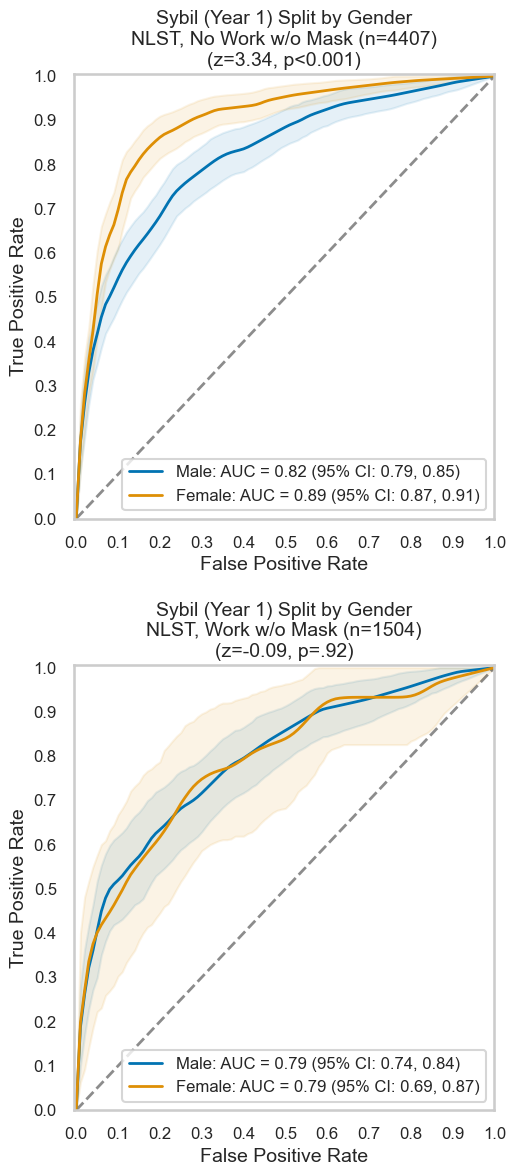

In [65]:
_ = roc.plot_rocs_isolate_confounder(
    nlst_5911,
    'Gender',
    'Work w/o Mask',
    models={'Sybil (Year 1)': 'sybil_year1'},
    dataset_name="NLST",
    num_bootstraps=1000,
    imgpath=f"{FIG_DIR}/sybilROCgender-WrkNoMask.png"
)

### Race

In [66]:
race_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-race-by-factors-nlst-5911.csv', index_col=0)
race_prev_roc, race_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'WhiteOrBlack',
    NLST_POSSIBLE_CONFOUNDERS,
    race_roc,
    'Venkadesh21',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(race_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/raceIsolationPlusROC.tex",
    hrules=True, label='tab:raceIsolationPlusROC', environment='sidewaystable*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between White and Black patients, and the ROC AUC scores of the Venkadesh21 model between these racial groups isolating for them.'))

race_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:497: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:516: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df2.drop(columns=["Difference", "Abs Diff"]).droplevel(0)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

White                                  Black       \
                              Mal   Ben Total %            ROC AUC   Mal  Ben   
Confounder           Subset                                                     
Married              True     354  3405    68.1  0.89 (0.87, 0.91)    14   61   
                     False    176  1588    31.9  0.90 (0.88, 0.92)    14   99   
Cigarettes per Day   > 25     284  2383    48.3  0.90 (0.89, 0.92)     8   33   
                     ≤ 25     246  2610    51.7  0.88 (0.86, 0.90)    20  127   
Pack-Years           ≤ 55     249  2877    56.6  0.88 (0.86, 0.90)    23  125   
                     > 55     281  2116    43.4  0.90 (0.88, 0.91)     5   35   
Hypertension Diag.   False    329  3373    67.0  0.90 (0.89, 0.92)    12   74   
                     True     196  1617    32.8  0.87 (0.84, 0.90)    16   86   
Current Smoker       True     283  2451    49.5  0.89 (0.87, 0.91)    17  112   
                     False    247  2542    50.5  0.89 (0.87, 0.91)    11   48   
Unfinished Education False    394  3663    73.5  0.89 (0.88, 0.91)    13   96   
                     True     136  1330    26.5  0.89 (0.86, 0.92)    15   64   
Smoked Pipe          True     132  1127    22.8  0.90 (0.87, 0.92)     5   12   
                     False    397  3837    76.7  0.89 (0.87, 0.91)    23  145   
Gender               Female   218  2084    41.7  0.89 (0.87, 0.91)    15   88   
                     Male     312  2909    58.3  0.89 (0.87, 0.91)    13   72   
Diabetes Diag.       False    480  4578    91.6  0.89 (0.88, 0.90)    24  129   
                     True      50   412     8.4  0.90 (0.86, 0.94)     4   31   
Height               ≤ 68     282  2604    52.3  0.89 (0.87, 0.91)    17  100   
                     > 68     248  2389    47.7  0.89 (0.87, 0.91)    11   60   

                                                          p  
                            Total %            ROC AUC       
Confounder           Subset                                  
Married              True      39.9  0.74 (0.60, 0.86)  .04  
                     False     60.1  0.87 (0.76, 0.96)  .66  
Cigarettes per Day   > 25      21.8  0.94 (0.85, 1.00)  .50  
                     ≤ 25      78.2  0.77 (0.67, 0.87)  .08  
Pack-Years           ≤ 55      78.7  0.79 (0.69, 0.88)  .10  
                     > 55      21.3  0.93 (0.83, 1.00)  .63  
Hypertension Diag.   False     45.7  0.93 (0.87, 0.98)  .60  
                     True      54.3  0.73 (0.61, 0.85)  .04  
Current Smoker       True      68.6  0.76 (0.62, 0.88)  .05  
                     False     31.4  0.88 (0.77, 0.96)  .80  
Unfinished Education False     58.0  0.81 (0.70, 0.92)  .26  
                     True      42.0  0.84 (0.72, 0.94)  .43  
Smoked Pipe          True       9.0  0.93 (0.77, 1.00)  .75  
                     False     89.4  0.80 (0.70, 0.89)  .11  
Gender               Female    54.8  0.84 (0.75, 0.92)  .40  
                     Male      45.2  0.81 (0.66, 0.93)  .24  
Diabetes Diag.       False     81.4  0.83 (0.74, 0.91)  .26  
                     True      18.6  0.67 (0.32, 1.00)  .11  
Height               ≤ 68      62.2  0.84 (0.76, 0.92)  .36  
                     > 68      37.8  0.78 (0.61, 0.93)  .19

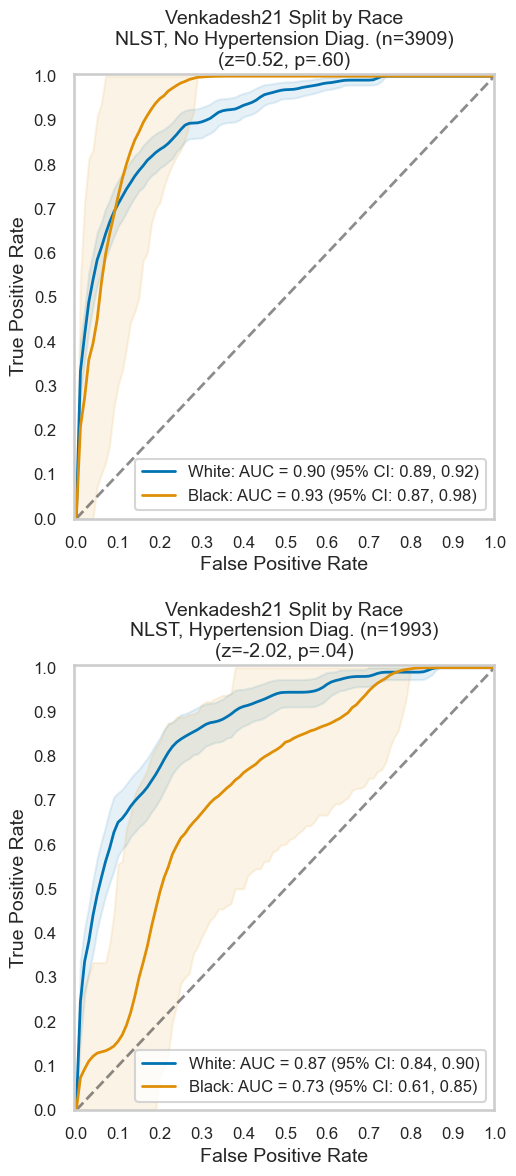

In [67]:
_ = roc.plot_rocs_isolate_confounder(
    nlst_5911,
    'Race',
    'Hypertension Diag.',
    models={'Venkadesh21': 'DL_cal'},
    dataset_name="NLST",
    num_bootstraps=1000,
    imgpath=f"{FIG_DIR}/venkROCrace-Hypertension.png"
)

### BMI

In [68]:
bmi_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-bmi-by-factors-nlst-5911.csv', index_col=0)
bmi_prev_roc, bmi_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'Overweight',
    NLST_POSSIBLE_CONFOUNDERS,
    bmi_roc,
    'Sybil (Year 1)',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(bmi_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiIsolationPlusROC.tex",
    hrules=True, label='tab:bmiIsolationPlusROC', environment='sidewaystable*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between high and low BMI patients, and the ROC AUC scores of the Sybil (Year 1) model between BMI groups isolating for them.'))

bmi_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:497: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:529: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

< 25                                  ≥ 25  \
                               Mal   Ben Total %            ROC AUC  Mal   
Confounder             Subset                                              
Weight                 ≤ 180   199  1600    94.7  0.81 (0.78, 0.84)  135   
                       > 180    10    90     5.3  0.93 (0.83, 0.99)  237   
Current Smoker         False    74   642    37.7  0.82 (0.76, 0.87)  193   
                       True    135  1048    62.3  0.81 (0.77, 0.86)  179   
Gender                 Female  117   879    52.4  0.85 (0.81, 0.89)  127   
                       Male     92   811    47.6  0.76 (0.70, 0.82)  245   
Emphysema in Scan      False   106   901    53.0  0.84 (0.79, 0.89)  211   
                       True    103   789    47.0  0.78 (0.73, 0.83)  161   
Hypertension Diag.     False   143  1292    75.6  0.82 (0.78, 0.85)  209   
                       True     62   397    24.2  0.80 (0.73, 0.86)  161   
Height                 > 68     71   680    39.5  0.77 (0.70, 0.83)  196   
                       ≤ 68    138  1010    60.5  0.84 (0.81, 0.88)  176   
Married                False    88   659    39.3  0.85 (0.81, 0.89)  109   
                       True    121  1031    60.7  0.79 (0.74, 0.83)  263   
Total Years of Smoking > 40    142   983    59.2  0.79 (0.75, 0.84)  248   
                       ≤ 40     67   707    40.8  0.85 (0.80, 0.90)  124   
Smoked Pipe            False   174  1403    83.0  0.83 (0.80, 0.87)  262   
                       True     34   280    16.5  0.74 (0.63, 0.84)  109   
Diabetes Diag.         True      6    62     3.6  0.99 (1.00, 1.00)   51   
                       False   202  1625    96.2  0.81 (0.77, 0.84)  321   

                                                                     p  
                                Ben Total %            ROC AUC          
Confounder             Subset                                           
Weight                 ≤ 180   1161    32.3  0.89 (0.86, 0.92)    .002  
                       > 180   2479    67.7  0.84 (0.81, 0.87)     .12  
Current Smoker         False   2021    55.2  0.85 (0.82, 0.88)     .30  
                       True    1619    44.8  0.86 (0.84, 0.89)     .07  
Gender                 Female  1347    36.7  0.90 (0.87, 0.93)     .11  
                       Male    2293    63.3  0.83 (0.80, 0.86)     .03  
Emphysema in Scan      False   2537    68.5  0.88 (0.86, 0.91)     .10  
                       True    1103    31.5  0.81 (0.77, 0.85)     .44  
Hypertension Diag.     False   2265    61.7  0.88 (0.85, 0.90)     .02  
                       True    1373    38.2  0.82 (0.79, 0.85)     .55  
Height                 > 68    1820    50.2  0.82 (0.78, 0.85)     .19  
                       ≤ 68    1820    49.8  0.89 (0.87, 0.92)     .04  
Married                False   1081    29.7  0.89 (0.85, 0.92)     .22  
                       True    2559    70.3  0.84 (0.82, 0.87)     .07  
Total Years of Smoking > 40    1782    50.6  0.86 (0.84, 0.88)    .009  
                       ≤ 40    1858    49.4  0.84 (0.80, 0.88)     .69  
Smoked Pipe            False   2736    74.7  0.86 (0.84, 0.89)     .15  
                       True     878    24.6  0.83 (0.79, 0.87)     .09  
Diabetes Diag.         True     426    11.9  0.82 (0.75, 0.88)  < .001  
                       False   3214    88.1  0.86 (0.84, 0.88)     .01

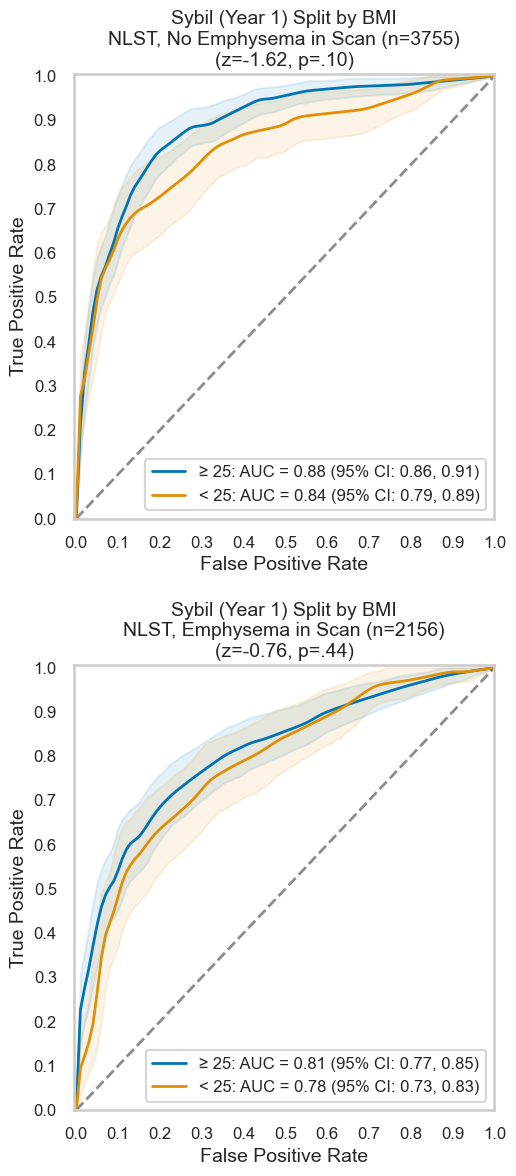

In [69]:
_ = roc.plot_rocs_isolate_confounder(
    nlst_5911,
    'BMI',
    'Emphysema in Scan',
    models={'Sybil (Year 1)': 'sybil_year1'},
    dataset_name="NLST",
    num_bootstraps=1000,
    imgpath=f"{FIG_DIR}/sybilROCbmi-Emphysema.png"
)

## Thresholds, isolating for confounders

### Gender

In [70]:
gender_pairwise_comps = None

In [71]:
gender_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-gender-by-factors-nlst-5911.csv', index_col=0)
gender_tpr_tnr, gender_pairwise_comps = output.threshold_isolation_pairwise(
    gender_isolations, "Gender", "Sybil (Year 1)", 
    nlst_5911_policies, 
    topn_confs=gender_topn_confounders, 
    pairwise_comps=gender_pairwise_comps)
gender_tpr_tnr

TPR (90% Specificity)                         \
                                           Male             Female  CI   
Confounder         Subset                                                
Height             > 68       0.52 (0.46, 0.58)  0.60 (0.25, 0.92)       
                   ≤ 68       0.55 (0.44, 0.65)  0.66 (0.60, 0.72)   *   
Weight             > 180      0.56 (0.50, 0.63)  0.64 (0.48, 0.79)       
                   ≤ 180      0.48 (0.38, 0.56)  0.66 (0.60, 0.72)  **   
Smoked Pipe        False      0.56 (0.48, 0.63)  0.65 (0.59, 0.71)   *   
                   True       0.49 (0.40, 0.57)  1.00 (1.00, 1.00)  **   
Smoked Cigars      False      0.56 (0.49, 0.63)  0.65 (0.59, 0.71)   *   
                   True       0.45 (0.36, 0.55)  0.86 (0.50, 1.00)   *   
Married            False      0.48 (0.37, 0.60)  0.74 (0.66, 0.81)  **   
                   True       0.54 (0.49, 0.60)  0.57 (0.49, 0.65)       
Work w/o Mask      False      0.53 (0.46, 0.59)  0.68 (0.62, 0.75)  **   
                   True       0.52 (0.42, 0.62)  0.47 (0.29, 0.64)       
Pack-Years         > 55       0.54 (0.47, 0.60)  0.73 (0.64, 0.82)  **   
                   ≤ 55       0.52 (0.44, 0.60)  0.60 (0.53, 0.68)   *   
BMI                < 25       0.50 (0.40, 0.60)  0.66 (0.57, 0.74)   *   
                   ≥ 25       0.54 (0.47, 0.60)  0.65 (0.57, 0.73)   *   
Cigarettes per Day > 25       0.54 (0.46, 0.61)  0.74 (0.66, 0.83)  **   
                   ≤ 25       0.51 (0.43, 0.59)  0.59 (0.51, 0.67)       
Lived w/ Smoker    False      0.51 (0.36, 0.67)  0.57 (0.33, 0.79)       
                   True       0.53 (0.47, 0.59)  0.67 (0.61, 0.72)  **   

                          TNR (90% Sensitivity)                         
                                           Male             Female  CI  
Confounder         Subset                                               
Height             > 68       0.45 (0.43, 0.47)  0.47 (0.40, 0.56)      
                   ≤ 68       0.49 (0.46, 0.53)  0.57 (0.55, 0.59)  **  
Weight             > 180      0.48 (0.46, 0.50)  0.63 (0.59, 0.67)  **  
                   ≤ 180      0.42 (0.39, 0.45)  0.54 (0.52, 0.56)  **  
Smoked Pipe        False      0.46 (0.44, 0.48)  0.56 (0.54, 0.58)  **  
                   True       0.47 (0.44, 0.50)  0.47 (0.32, 0.63)      
Smoked Cigars      False      0.46 (0.44, 0.48)  0.56 (0.54, 0.58)  **  
                   True       0.48 (0.45, 0.51)  0.67 (0.56, 0.77)  **  
Married            False      0.48 (0.44, 0.52)  0.55 (0.52, 0.58)  **  
                   True       0.46 (0.44, 0.48)  0.57 (0.54, 0.60)  **  
Work w/o Mask      False      0.48 (0.46, 0.50)  0.57 (0.55, 0.59)  **  
                   True       0.43 (0.40, 0.46)  0.52 (0.46, 0.58)   *  
Pack-Years         > 55       0.43 (0.41, 0.46)  0.54 (0.51, 0.58)  **  
                   ≤ 55       0.49 (0.47, 0.51)  0.57 (0.55, 0.60)  **  
BMI                < 25       0.41 (0.38, 0.44)  0.51 (0.47, 0.54)  **  
                   ≥ 25       0.48 (0.46, 0.50)  0.60 (0.57, 0.62)  **  
Cigarettes per Day > 25       0.45 (0.43, 0.47)  0.57 (0.53, 0.60)  **  
                   ≤ 25       0.48 (0.45, 0.50)  0.56 (0.53, 0.58)  **  
Lived w/ Smoker    False      0.46 (0.42, 0.50)  0.53 (0.44, 0.63)      
                   True       0.46 (0.44, 0.48)  0.56 (0.54, 0.58)  **

In [72]:
print(gender_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/genderTPRandTNRisolated.tex",
    hrules=True, label='tab:genderTPRandTNRisolated', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity (TPR) and Specificity (TNR) at specific thresholds with 95\% Confidence Intervals (CI) for the Sybil (Year 1) model between men and women, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between genders. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### Race

In [73]:
race_pairwise_comps = None

In [74]:
race_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-race-by-factors-nlst-5911.csv', index_col=0)
race_tpr_tnr, race_pairwise_comps = output.threshold_isolation_pairwise(
    race_isolations, "WhiteOrBlack", "Venkadesh21", 
    nlst_5911_policies, 
    topn_confs=race_topn_confounders, 
    pairwise_comps=race_pairwise_comps)
race_tpr_tnr

TPR (90% Specificity)                         \
                                            White              Black  CI   
Confounder           Subset                                                
Married              False      0.76 (0.69, 0.82)  0.50 (0.20, 0.79)       
                     True       0.66 (0.60, 0.70)  0.29 (0.07, 0.55)  **   
Cigarettes per Day   > 25       0.72 (0.66, 0.77)  0.75 (0.38, 1.00)       
                     ≤ 25       0.65 (0.60, 0.72)  0.25 (0.06, 0.45)  **   
Pack-Years           > 55       0.71 (0.65, 0.75)  0.60 (0.00, 1.00)       
                     ≤ 55       0.67 (0.61, 0.72)  0.35 (0.15, 0.53)  **   
Hypertension Diag.   False      0.71 (0.66, 0.76)  0.67 (0.38, 0.92)       
                     True       0.65 (0.59, 0.72)  0.19 (0.00, 0.40)  **   
Current Smoker       False      0.67 (0.60, 0.73)  0.36 (0.09, 0.67)   *   
                     True       0.71 (0.65, 0.76)  0.41 (0.17, 0.64)  **   
Unfinished Education False      0.67 (0.62, 0.72)  0.31 (0.07, 0.58)  **   
                     True       0.75 (0.67, 0.81)  0.47 (0.20, 0.71)   *   
Smoked Pipe          False      0.70 (0.66, 0.75)  0.43 (0.22, 0.65)  **   
                     True       0.65 (0.57, 0.73)  0.20 (0.00, 0.67)       
Gender               Female     0.72 (0.66, 0.78)  0.40 (0.14, 0.67)   *   
                     Male       0.66 (0.61, 0.72)  0.38 (0.10, 0.67)       
Diabetes Diag.       False      0.69 (0.64, 0.73)  0.38 (0.19, 0.56)  **   
                     True       0.72 (0.59, 0.84)  0.50 (0.00, 1.00)       
Height               > 68       0.66 (0.60, 0.72)  0.36 (0.09, 0.69)       
                     ≤ 68       0.71 (0.66, 0.77)  0.41 (0.15, 0.67)   *   

                            TNR (90% Sensitivity)                         
                                            White              Black  CI  
Confounder           Subset                                               
Married              False      0.63 (0.61, 0.66)  0.76 (0.68, 0.84)  **  
                     True       0.67 (0.65, 0.69)  0.69 (0.57, 0.81)      
Cigarettes per Day   > 25       0.66 (0.64, 0.68)  0.70 (0.52, 0.84)      
                     ≤ 25       0.66 (0.64, 0.68)  0.74 (0.66, 0.81)   *  
Pack-Years           > 55       0.65 (0.62, 0.67)  0.71 (0.57, 0.86)      
                     ≤ 55       0.67 (0.65, 0.69)  0.74 (0.66, 0.81)      
Hypertension Diag.   False      0.67 (0.65, 0.68)  0.72 (0.62, 0.82)      
                     True       0.64 (0.61, 0.66)  0.74 (0.65, 0.84)   *  
Current Smoker       False      0.66 (0.65, 0.68)  0.77 (0.65, 0.89)      
                     True       0.65 (0.63, 0.67)  0.71 (0.62, 0.79)      
Unfinished Education False      0.66 (0.65, 0.68)  0.82 (0.74, 0.90)  **  
                     True       0.64 (0.62, 0.67)  0.59 (0.47, 0.71)      
Smoked Pipe          False      0.66 (0.65, 0.68)  0.71 (0.64, 0.78)      
                     True       0.65 (0.62, 0.68)  0.92 (0.73, 1.00)  **  
Gender               Female     0.68 (0.66, 0.70)  0.73 (0.63, 0.82)      
                     Male       0.64 (0.63, 0.66)  0.74 (0.64, 0.84)      
Diabetes Diag.       False      0.66 (0.64, 0.67)  0.73 (0.66, 0.81)      
                     True       0.66 (0.61, 0.70)  0.74 (0.58, 0.88)      
Height               > 68       0.64 (0.62, 0.66)  0.77 (0.64, 0.87)   *  
                     ≤ 68       0.68 (0.66, 0.69)  0.71 (0.62, 0.80)

In [75]:
print(race_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/raceTPRandTNRisolated.tex",
    hrules=True, label='tab:raceTPRandTNRisolated', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity (TPR) and Specificity (TNR) at specific thresholds with 95\% Confidence Intervals (CI) for the Venkadesh21 model between between White and Black patients, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between racial groups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### BMI

In [76]:
bmi_pairwise_comps = None

In [77]:
bmi_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-bmi-by-factors-nlst-5911.csv', index_col=0)
bmi_tpr_tnr, bmi_pairwise_comps = output.threshold_isolation_pairwise(
    bmi_isolations, "Overweight", "Sybil (Year 1)", 
    nlst_5911_policies, 
    topn_confs=bmi_topn_confounders, 
    pairwise_comps=bmi_pairwise_comps)
bmi_tpr_tnr

TPR (90% Specificity)                         \
                                               ≥ 25               < 25  CI   
Confounder             Subset                                                
Weight                 > 180      0.56 (0.50, 0.62)  0.80 (0.50, 1.00)       
                       ≤ 180      0.61 (0.52, 0.69)  0.58 (0.51, 0.64)       
Current Smoker         False      0.57 (0.50, 0.64)  0.57 (0.46, 0.69)       
                       True       0.59 (0.51, 0.67)  0.60 (0.52, 0.68)       
Gender                 Female     0.65 (0.57, 0.74)  0.66 (0.57, 0.74)       
                       Male       0.54 (0.48, 0.60)  0.50 (0.40, 0.61)       
Emphysema in Scan      False      0.60 (0.54, 0.66)  0.60 (0.51, 0.69)       
                       True       0.55 (0.46, 0.62)  0.57 (0.47, 0.67)       
Hypertension Diag.     False      0.63 (0.57, 0.70)  0.56 (0.48, 0.64)       
                       True       0.51 (0.43, 0.59)  0.65 (0.53, 0.76)   *   
Height                 > 68       0.54 (0.47, 0.60)  0.49 (0.38, 0.60)       
                       ≤ 68       0.62 (0.55, 0.70)  0.64 (0.56, 0.72)       
Married                False      0.66 (0.57, 0.75)  0.61 (0.52, 0.72)       
                       True       0.54 (0.49, 0.61)  0.57 (0.48, 0.66)       
Total Years of Smoking > 40       0.59 (0.53, 0.65)  0.59 (0.51, 0.67)       
                       ≤ 40       0.56 (0.46, 0.65)  0.58 (0.46, 0.70)       
Smoked Pipe            False      0.60 (0.54, 0.66)  0.61 (0.54, 0.69)       
                       True       0.51 (0.42, 0.61)  0.47 (0.29, 0.63)       
Diabetes Diag.         False      0.57 (0.52, 0.63)  0.58 (0.51, 0.65)       
                       True       0.61 (0.48, 0.75)  1.00 (1.00, 1.00)  **   

                              TNR (90% Sensitivity)                         
                                               ≥ 25               < 25  CI  
Confounder             Subset                                               
Weight                 > 180      0.51 (0.49, 0.53)  0.54 (0.44, 0.64)      
                       ≤ 180      0.55 (0.52, 0.58)  0.45 (0.43, 0.48)  **  
Current Smoker         False      0.52 (0.50, 0.55)  0.50 (0.46, 0.54)      
                       True       0.53 (0.50, 0.55)  0.43 (0.40, 0.47)  **  
Gender                 Female     0.60 (0.57, 0.62)  0.51 (0.47, 0.54)  **  
                       Male       0.48 (0.46, 0.50)  0.41 (0.37, 0.45)  **  
Emphysema in Scan      False      0.56 (0.54, 0.58)  0.51 (0.48, 0.55)   *  
                       True       0.44 (0.41, 0.47)  0.40 (0.36, 0.43)   *  
Hypertension Diag.     False      0.55 (0.53, 0.57)  0.46 (0.43, 0.49)  **  
                       True       0.48 (0.46, 0.51)  0.46 (0.41, 0.51)      
Height                 > 68       0.48 (0.46, 0.50)  0.39 (0.35, 0.43)  **  
                       ≤ 68       0.57 (0.55, 0.59)  0.50 (0.47, 0.54)  **  
Married                False      0.54 (0.51, 0.57)  0.50 (0.46, 0.54)   *  
                       True       0.52 (0.50, 0.54)  0.43 (0.40, 0.46)  **  
Total Years of Smoking > 40       0.49 (0.46, 0.51)  0.42 (0.39, 0.45)  **  
                       ≤ 40       0.56 (0.54, 0.58)  0.51 (0.48, 0.55)   *  
Smoked Pipe            False      0.54 (0.52, 0.55)  0.47 (0.44, 0.49)  **  
                       True       0.49 (0.45, 0.52)  0.42 (0.36, 0.48)   *  
Diabetes Diag.         False      0.53 (0.51, 0.54)  0.46 (0.43, 0.48)  **  
                       True       0.52 (0.48, 0.57)  0.55 (0.43, 0.67)

In [78]:
print(bmi_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiTPRandTNRisolated.tex",
    hrules=True, label='tab:bmiTPRandTNRisolated', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity (TPR) and Specificity (TNR) at specific thresholds with 95\% Confidence Intervals (CI) for the Sybil (Year 1) model between between high and low BMI patients, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between racial groups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None
